In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
from tensorflow.keras.applications import ResNet50

In [2]:
path='../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = ResNet50(include_top=True,
                 weights= None,
                 input_shape=(224,224,3),
                 pooling='avg',
                 classes=2)

for layer in pre_trained_model.layers:
    layer.trainable=False
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [3]:
last_layer=pre_trained_model.get_layer('conv5_block2_add')

print('last layer output shape: ', last_layer.output_shape)

last_output=last_layer.output

last layer output shape:  (None, 7, 7, 2048)


In [4]:
from tensorflow.keras.optimizers import RMSprop,Adam

X=layers.Flatten()(last_output)

X=layers.Dense(512,activation='relu')(X)

X=layers.Dropout(0.2)(X)
X=layers.Dense(512,activation='relu')(X)

X=layers.Dropout(0.2)(X)

X=layers.Dense(2,activation='softmax')(X)

model=Model(pre_trained_model.input,X)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [5]:
# No. of test and train images of benign class
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/train/benign/')))
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/test/benign/')))

# No. of test and train images of maligant class
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/train/malignant/')))
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/test/malignant/')))

1440
360
1197
300


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir='../input/skin-cancer-malignant-vs-benign/train'

test_dir='../input/skin-cancer-malignant-vs-benign/test'

train_datagen = ImageDataGenerator(rescale=1/255)
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   rotation_range=40,
#                                   shear_range=0.2,
#                                   zoom_range=0.2,
#                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  
                                                  class_mode='categorical')
test_generator=test_datagen.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                
                                                class_mode='categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# cb_early_stopper = EarlyStopping(monitor = 'val_accuracy', patience = 10)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [8]:
history=model.fit(train_generator,
                  validation_data=test_generator,
                  steps_per_epoch=50,
                  epochs=15,
                  validation_steps = 12,
                  batch_size=20,
                  verbose = 1,
                  callbacks=[cb_checkpointer])

model.load_weights("../working/best.hdf5")

Epoch 1/15
50/50 [==============================] - 13s 264ms/step - loss: 1.1133 - accuracy: 0.5387 - val_loss: 0.6703 - val_accuracy: 0.5495
Epoch 2/15
50/50 [==============================] - 10s 208ms/step - loss: 0.6825 - accuracy: 0.5882 - val_loss: 0.6278 - val_accuracy: 0.7630
Epoch 3/15
50/50 [==============================] - 10s 195ms/step - loss: 0.6657 - accuracy: 0.6034 - val_loss: 0.5960 - val_accuracy: 0.6667
Epoch 4/15
50/50 [==============================] - 9s 177ms/step - loss: 0.5789 - accuracy: 0.6863 - val_loss: 0.5922 - val_accuracy: 0.6016
Epoch 5/15
50/50 [==============================] - 9s 172ms/step - loss: 0.6034 - accuracy: 0.6496 - val_loss: 0.5383 - val_accuracy: 0.7552
Epoch 6/15
50/50 [==============================] - 10s 192ms/step - loss: 0.5587 - accuracy: 0.6831 - val_loss: 0.5132 - val_accuracy: 0.7682
Epoch 7/15
50/50 [==============================] - 9s 186ms/step - loss: 0.5518 - accuracy: 0.6958 - val_loss: 0.4727 - val_accuracy: 0.7708
Ep

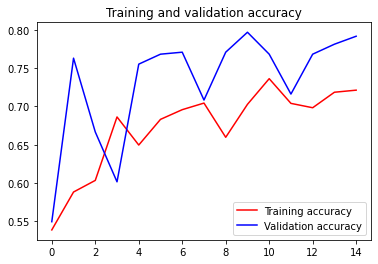

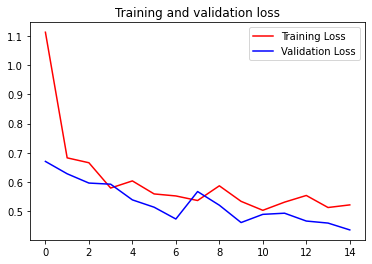

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [10]:
import h5py
model.save('mymodel.h5')
model.save('mymodel')

In [11]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img,img_to_array,array_to_img
from keras.models import load_model
model=load_model('./mymodel.h5')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [12]:
def classify(path):
    model=load_model('./mymodel.h5')
    image=load_img(path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image=preprocess_input(image)
    result=model.predict(image)
    print(result)

In [13]:
classify('../input/skin-cancer-malignant-vs-benign/test/benign/1044.jpg')

[[0.3725053  0.62749475]]
